In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import ResNet50
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow.keras.callbacks import *
import os
import shutil
from sklearn.model_selection import train_test_split

2024-02-22 11:52:09.135479: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 11:52:09.135612: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-22 11:52:09.287760: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!rm -r '/kaggle/working/data'

rm: cannot remove '/kaggle/working/data': No such file or directory


In [4]:
src_dir = '/kaggle/input/ck-dataset'
train_dir = '/kaggle/working/data/train'
test_dir = '/kaggle/working/data/test'

classes_list = os.listdir(src_dir)

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for class_name in classes_list:
    class_files = os.listdir(os.path.join(src_dir, class_name))
    
    train_files, test_files = train_test_split(class_files, test_size=0.22, random_state=42)
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    for file_name in train_files:
        shutil.copy(os.path.join(src_dir, class_name, file_name), os.path.join(train_dir, class_name, file_name))
    
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
    for file_name in test_files:
        shutil.copy(os.path.join(src_dir, class_name, file_name), os.path.join(test_dir, class_name, file_name))

In [5]:
img = cv2.imread('/kaggle/input/ck-dataset/anger/S010_004_00000017.png')
print(img.shape)
img_size = img.shape[0]

(48, 48, 3)


In [6]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


In [7]:
train_dir = "/kaggle/working/data/train"
test_dir = "/kaggle/working/data/test"

In [8]:
Train_Datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)
Val_Datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)

train_generator = Train_Datagen.flow_from_directory(directory = train_dir, target_size = (224, 224), 
                                       batch_size = 32, class_mode = 'categorical', seed=42, shuffle=False, subset = "training", classes = ["anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"])

validation_generator = Val_Datagen.flow_from_directory(directory = test_dir, target_size = (224, 224), 
                                       batch_size = 32, class_mode = 'categorical', seed=42, shuffle=False, classes = ["anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"])

Found 763 images belonging to 7 classes.
Found 218 images belonging to 7 classes.


In [9]:
x = Flatten() (base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.15)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
prediction = Dense(len(os.listdir(train_dir)), activation = 'softmax')(x)

In [10]:
model = Model(inputs = base_model.input, outputs = prediction)

In [11]:
model.compile (
    loss = 'categorical_crossentropy',
    optimizer = Adam(lr=0.1),
    metrics = ['accuracy']
)

In [12]:
checkpoint = ModelCheckpoint('emotion_detection.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             save_weights_only=False,
                             restore_best_weights=True,
                             period=15)

In [13]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    epochs=120,
    callbacks=checkpoint
)

Epoch 1/120


I0000 00:00:1708602795.061061     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23/23 [==============================] - 18s 296ms/step - loss: 18.5492 - accuracy: 0.1491 - val_loss: 2.4612 - val_accuracy: 0.2344
Epoch 2/120
23/23 [==============================] - 4s 152ms/step - loss: 3.9585 - accuracy: 0.1751 - val_loss: 1.8227 - val_accuracy: 0.3698
Epoch 3/120
23/23 [==============================] - 4s 152ms/step - loss: 2.3647 - accuracy: 0.1710 - val_loss: 1.8753 - val_accuracy: 0.2448
Epoch 4/120
23/23 [==============================] - 4s 151ms/step - loss: 2.1340 - accuracy: 0.1765 - val_loss: 1.8377 - val_accuracy: 0.3073
Epoch 5/120
23/23 [==============================] - 4s 152ms/step - loss: 1.9261 - accuracy: 0.2585 - val_loss: 1.7126 - val_accuracy: 0.4427
Epoch 6/120
23/23 [==============================] - 4s 153ms/step - loss: 1.7716 - accuracy: 0.2982 - val_loss: 1.5976 - val_accuracy: 0.4115
Epoch 7/120
23/23 [==============================] - 4s 154ms/step - loss: 1.6831 - accuracy: 0.3573 - val_loss: 1.6611 - val_accuracy: 0.4062
Epoch 8/1

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/23 [==============================] - 7s 287ms/step - loss: 1.0589 - accuracy: 0.5828 - val_loss: 0.9528 - val_accuracy: 0.6042
Epoch 16/120
23/23 [==============================] - 4s 156ms/step - loss: 0.8788 - accuracy: 0.6334 - val_loss: 0.8607 - val_accuracy: 0.6406
Epoch 17/120
23/23 [==============================] - 4s 156ms/step - loss: 0.9964 - accuracy: 0.6224 - val_loss: 0.9603 - val_accuracy: 0.6250
Epoch 18/120
23/23 [==============================] - 4s 156ms/step - loss: 0.9810 - accuracy: 0.6047 - val_loss: 0.8762 - val_accuracy: 0.6354
Epoch 19/120
23/23 [==============================] - 4s 157ms/step - loss: 0.8906 - accuracy: 0.6252 - val_loss: 0.7359 - val_accuracy: 0.6771
Epoch 20/120
23/23 [==============================] - 4s 157ms/step - loss: 0.8646 - accuracy: 0.6648 - val_loss: 0.9677 - val_accuracy: 0.6771
Epoch 21/120
23/23 [==============================] - 4s 158ms/step - loss: 0.8142 - accuracy: 0.6576 - val_loss: 0.7738 - val_accuracy: 0.6354
Epoch

In [15]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

7/7 [==============================] - 1s 106ms/step - loss: 0.0748 - accuracy: 0.9862
final train accuracy = 100.00 , validation accuracy = 98.62


In [16]:
from sklearn.metrics import classification_report
import numpy as np

y_true = validation_generator.classes

y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

class_names = list(validation_generator.class_indices.keys())
print(class_names)

report = classification_report(y_true, y_pred_classes, target_names=class_names)
print(report)

7/7 [==============================] - 2s 102ms/step
['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']
              precision    recall  f1-score   support

       anger       1.00      1.00      1.00        30
    contempt       1.00      1.00      1.00        12
     disgust       1.00      1.00      1.00        39
        fear       1.00      0.88      0.94        17
       happy       1.00      1.00      1.00        46
     sadness       0.95      1.00      0.97        19
    surprise       0.96      0.98      0.97        55

    accuracy                           0.99       218
   macro avg       0.99      0.98      0.98       218
weighted avg       0.99      0.99      0.99       218



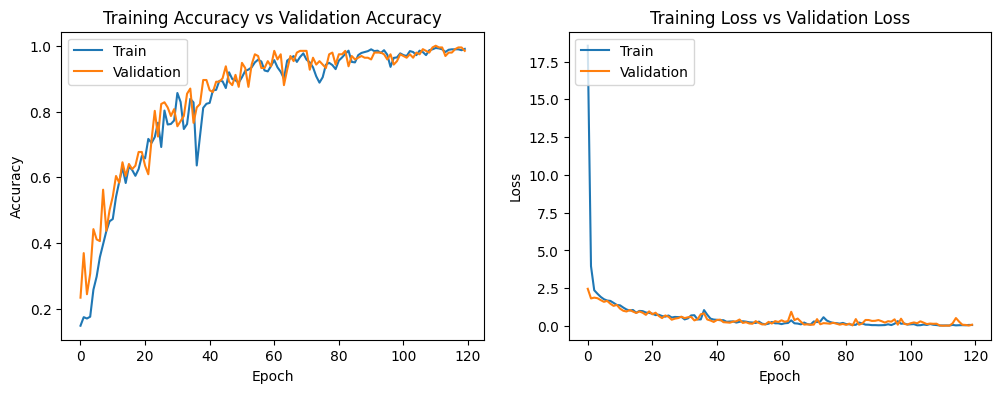

In [17]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [18]:
from huggingface_hub import push_to_hub_keras

push_to_hub_keras(model,
    "DShah-11/emotion_detection_v2",
    tags = ["object-detection"],
)

fingerprint.pb:   0%|          | 0.00/55.0 [00:00<?, ?B/s]

keras_metadata.pb:   0%|          | 0.00/401k [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

saved_model.pb:   0%|          | 0.00/2.94M [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/509M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/DShah-11/emotion_detection_v2/commit/ae63b9cc9b14e5ee554e367cbe6754751d95d758', commit_message='Push Keras model using huggingface_hub.', commit_description='', oid='ae63b9cc9b14e5ee554e367cbe6754751d95d758', pr_url=None, pr_revision=None, pr_num=None)

# Inference

In [1]:
!pip install huggingface_hub["tensorflow"]

In [26]:
from keras.preprocessing import image
import numpy as np
from tensorflow.keras.applications.resnet import preprocess_input
import cv2

# Load and preprocess the image
img_path = "/kaggle/input/ck-dataset/anger/S011_004_00000019.png"
img = image.load_img(img_path)
img_array = image.img_to_array(img)
img_resized = cv2.resize(img_array, (224, 224))
img_array = np.expand_dims(img_resized, axis=0) 
img_array = preprocess_input(img_array)

In [24]:
from huggingface_hub import from_pretrained_keras

model = from_pretrained_keras("DShah-11/emotion_detection_v2")

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

In [27]:
classes = ["anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"]
prediction = model.predict(img_array)
print(prediction)

1/1 [==============================] - 2s 2s/step
[[1.0000000e+00 1.9448512e-27 1.5740200e-29 3.3525463e-31 5.4314345e-38
  3.1714360e-11 0.0000000e+00]]


In [28]:
prediction = np.squeeze(np.round(prediction))
print(prediction)
print(f'The image is a {classes[int(np.argmax(prediction))]}!')

[1. 0. 0. 0. 0. 0. 0.]
The image is a anger!
